In [1]:
from tensorflow.keras import Sequential
import numpy as np
import optuna
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from egbz.utils import *

In [1]:
# Dataset suivi https://www.data.gouv.fr/fr/datasets/synthese-des-indicateurs-de-suivi-de-lepidemie-covid-19/
link = 'https://www.data.gouv.fr/fr/datasets/r/5c4e1452-3850-4b59-b11c-3dd51d7fb8b5'
df = pd.read_csv(link)

<IPython.core.display.Javascript object>

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
df

,dep,date,reg,lib_dep,lib_reg,tx_pos,tx_incid,TO,R,hosp,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
0,01,2020-03-18,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.062612,NaN,2,...,0,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2020-03-19,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.132379,NaN,2,...,0,79,1.0,0.0,0.0,0.0,44.0,NaN,NaN,NaN
2,01,2020-03-20,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.155635,NaN,2,...,0,87,0.0,0.0,1.0,0.0,16.0,NaN,NaN,NaN
3,01,2020-03-21,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.173524,NaN,4,...,0,88,3.0,0.0,0.0,0.0,15.0,NaN,NaN,NaN
4,01,2020-03-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.212880,NaN,8,...,0,106,3.0,1.0,1.0,0.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53222,976,2021-08-22,6,Mayotte,Mayotte,1.201147,23.973865,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,3.0,67.0,NaN
53223,976,2021-08-23,6,Mayotte,Mayotte,1.441578,27.194235,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,24.0,76.0,NaN
53224,976,2021-08-24,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
53225,976,2021-08-25,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,34.3


In [5]:
dataset = create_dataset(df, zone_col='dep', time_col='date')

In [109]:
from_df(df, time_col='date', cat_cols=['dep'], value_cols=['hosp', 'rea']).data_array()

<xarray.DataArray (time: 527, component: 202, sample: 1)>
array([[[ 2.],
        [ 0.],
        [41.],
        ...,
        [ 2.],
        [ 0.],
        [ 0.]],

       [[ 2.],
        [ 0.],
        [43.],
        ...,
        [ 2.],
        [ 0.],
        [ 0.]],

       [[ 2.],
        [ 0.],
        [52.],
        ...,
...
        ...,
        [44.],
        [ 1.],
        [ 0.]],

       [[77.],
        [ 9.],
        [48.],
        ...,
        [43.],
        [ 1.],
        [ 0.]],

       [[79.],
        [ 9.],
        [45.],
        ...,
        [44.],
        [ 1.],
        [ 0.]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-03-18 2020-03-19 ... 2021-08-26
  * component  (component) object 'hosp_01' 'rea_01' ... 'hosp_976' 'rea_976'
Dimensions without coordinates: sample

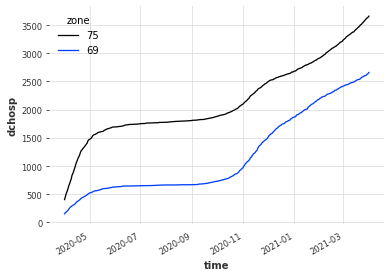

In [127]:
dataset['dchosp'].loc[['75', '69'], pd.date_range('2020-04-01', '2021-04-01')].plot.line(x='time');

In [26]:
test = df[['date', 'dep']]

In [92]:
troll = df[['dep']].drop_duplicates().reset_index(drop=True)
troll['test_var'] = df.dep
troll['zone']= troll.dep
troll = troll.set_index('zone')
troll

,dep,test_var
zone,,
01,01,01
02,02,01
03,03,01
04,04,01
05,05,01
...,...,...
971,971,01
972,972,01
973,973,01


In [93]:
troll_dataset = troll.to_xarray()
troll_dataset

<xarray.Dataset>
Dimensions:   (zone: 101)
Coordinates:
  * zone      (zone) object '01' '02' '03' '04' '05' ... '972' '973' '974' '976'
Data variables:
    dep       (zone) object '01' '02' '03' '04' '05' ... '972' '973' '974' '976'
    test_var  (zone) object '01' '01' '01' '01' '01' ... '01' '01' '01' '01'

In [100]:
TimeSeries.from_xarray(test[['hosp','rea']].to_array())

KeyError: 'component'

In [95]:
test = xr.merge([dataset, troll_dataset])

In [101]:
test

<xarray.Dataset>
Dimensions:        (time: 527, zone: 101)
Coordinates:
  * zone           (zone) object '01' '02' '03' '04' ... '972' '973' '974' '976'
  * time           (time) datetime64[ns] 2020-03-18 2020-03-19 ... 2021-08-26
Data variables: (12/22)
    reg            (zone, time) int64 84 84 84 84 84 84 84 84 ... 6 6 6 6 6 6 6
    lib_dep        (zone, time) object 'Ain' 'Ain' 'Ain' ... 'Mayotte' 'Mayotte'
    lib_reg        (zone, time) object 'Auvergne et Rhône-Alpes' ... 'Mayotte'
    tx_pos         (zone, time) float64 nan nan nan nan ... 1.442 nan nan nan
    tx_incid       (zone, time) float64 nan nan nan nan ... 27.19 nan nan nan
    TO             (zone, time) float64 0.06261 0.1324 0.1556 ... 0.0 0.0 0.0
    ...             ...
    reg_incid_rea  (zone, time) float64 nan 44.0 16.0 15.0 ... 0.0 0.0 0.0 0.0
    pos            (zone, time) float64 nan nan nan nan nan ... 24.0 nan nan nan
    pos_7j         (zone, time) float64 nan nan nan nan nan ... 76.0 nan nan nan
    cv_dose1       (zone, time) float64 nan nan nan nan nan ... nan nan 34.3 nan
    dep            (zone) object '01' '02' '03' '04' ... '972' '973' '974' '976'
    test_var       (zone) object '01' '01' '01' '01' ... '01' '01' '01' '01'

Cross-validation strategy
----------

Stratégie de validation croisée spatio-temporelle avec, prévision de *n* data_leakage=*l*, avec *k* fold temporels et fenêtre temporelle = (*start*, *end*) 

   - Pour chaque zone=*département* (100-fold)
   - Pour chaque moment=*timestamp* (k-fold)


   X = dataset[\
       zone = *zone*-département,\
       time = *start* -> min(*timestamp*+l+n, *end*)\
   ] + dataset[\
       zone = *département\
       time = start* -> *timestamp*

y = dataset[
    zone = département
    time = timestamp+1 -> timestamp + n

Prenons un exemple de fold avec une prévision n=7, data_leakage l=2, et une fenêtre temporelle de '2020-03-18' -> '2021-03-18', et 5-fold temporal cv

In [113]:
random_deps = np.random.choice(dataset.zone, size=5, replace=False)
start = '2020-03-18'
end = '2021-03-18'

<IPython.core.display.Javascript object>

In [119]:
study = optuna.create_study()

<IPython.core.display.Javascript object>

[I 2021-08-27 17:35:09,223] A new study created in memory with name: no-name-5297bf93-77cc-44bb-a96f-622cfa8b02ef


In [118]:
model = Sequential([
    Dense(2, activation='Relu'),
]

SyntaxError: unexpected EOF while parsing (849666168.py, line 3)

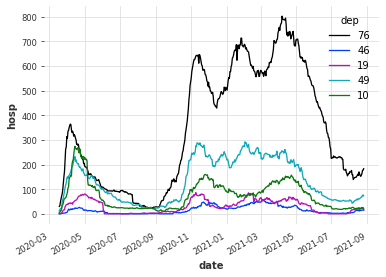

In [61]:
dataset['hosp'].sel(dep=random_deps).plot.line(x='date');

ValueError: x must be one of None, 'time', 'zone'

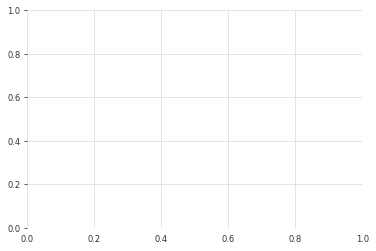

In [116]:
(
dataset['hosp']
     .sel(zone=random_deps, time=pd.date_range('2020-03-20', '2021-03-20'))
     .plot.line(x='date')
);

## Garbage

In [ ]:
ts['hosp_dep'].plot()

In [ ]:
ts = from_csv(link, cat_cols=['dep'], time_col='date', value_cols='hosp')
ts

In [ ]:
ts

In [ ]:
ts

In [ ]:
covid_df.query(' & '.join([f'{cat}=="{value}"' for cat, value in zip(['dep', 'lib_dep'], ['01', 'Ain'])]))

In [ ]:
time_col='date'
if time_col:
    datetime_series = pd.to_datetime(df[time_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df = df.set_index(datetime_index)
    df.drop(time_col, axis=1, inplace=True)

In [ ]:
categories = itertools.product(*['dep', 'lib_dep'])
for x in categories:
    print(str(x))

In [ ]:
cat_cols = ['lib_dep']
value_cols = ['hosp']
categories = itertools.product(*[df[cat].unique() for cat in cat_cols])
d = {f'{col}_{"_".join([x for x in cat])}': 
     df.query(' & '.join([f'{cat_name}=="{cat_value}"'
                            for cat_name, cat_value in zip(cat_cols, [x for x in cat])
                            ])
     )[col]
    for cat in categories
    for col in value_cols
}
pd.DataFrame(d)

In [ ]:
from egbz.utils import *

In [ ]:
plt.plot([1, 2 ,3]);

In [ ]:
df = df.query('dep=="01" | dep=="02"')

In [ ]:
ts = from_df(df, cat_cols=['dep', 'lib_dep'], time_col='date', value_cols=['hosp', 'rea'])

In [ ]:
ts.plot()

In [ ]:
import itertools

for x in itertools.product(*[df[cat].unique() for cat in ['dep', 'lib_dep']]):
    '_'.join([str(y) for y in x])

In [ ]:
'test'
'trolol'

In [ ]:
covid_df.query(' & '.join([f'{cat}=="{value}"' for cat, value in zip(['dep', 'lib_dep'], ['01', 'Ain'])]))

In [ ]:
covid_df.query('dep=="01"')

In [ ]:
df = covid_df
df

In [ ]:
ts.pd_dataframe()

In [ ]:
covid_df = pd.read_csv(link)

In [ ]:
covid_df

In [ ]:
d = {f'{cat}_{col}': cat for cat in covid_df['dep'].unique() for col in ['hosp']}
d

In [ ]:
TimeSeries.from_dataframe(covid_df[['dep','hosp']].query('dep=="01"'))

In [ ]:
from darts import TimeSeries

In [ ]:
TimeSeries.from_dataframe(covid_df[covid_df['dep']=='01'],
                         time_col='date',
                         value_cols='hosp')

In [ ]:
covid_df.keys()

In [ ]:
covid_df.groupby('dep').

In [ ]:
paris_df = covid_df.query('dep==75')

In [ ]:
df = covid_df[['date', 'dep', 'dchosp', 'hosp', 'rea']]
datetime_series = pd.to_datetime(df['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=df.set_index(datetime_index)
df.drop('date',axis=1,inplace=True)
df

In [ ]:
def series_train_test(
    data=covid_df, features=['hosp'],
    timestamp=pd.Timestamp('2021-01-01'), departement=75
):
    # Convert the index into a datetime index
    df = covid_df.query(f'dep=={departement}')[['date'] + features]
    datetime_series = pd.to_datetime(df['date'])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df=df.set_index(datetime_index)
    df.drop('date',axis=1,inplace=True)
    
    #
    time_series = {}
    train = {}
    test = {}
    for feature in features:
      series[feature] = TimeSeries.from_dataframe(df[[feature]]) 
      train[feature], test[feature] = time_series[feature].split_before(
          pd.Timestamp(timestamp)
      )
        
    return series, train, test

In [ ]:
time_series, train, test = time_series_train_test(data=paris_df, features['rea'])

In [ ]:
covid_df

In [ ]:
time_series['dchosp']

In [ ]:
train['hosp'].plot(label='train')
test['hosp'].plot(label='test')

In [ ]:
paris_df = covid_df.query('dep==75')[['date', 'TO', 'hosp', 'rea', 'dchosp']]

In [ ]:
paris_df.plot();

In [ ]:
paris_df.info()

In [ ]:
datetime_series = pd.to_datetime(paris_df['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=paris_df.set_index(datetime_index)
df.drop('date',axis=1,inplace=True)
df

In [ ]:

df.plot();

In [ ]:
train, val = series.split_before(pd.Timestamp('2021-01-01'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [ ]:
naive_model = NaiveSeasonal(K=158)
naive_model.fit(train)
naive_forecast = naive_model.predict(300)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=158)')
plt.legend();

In [ ]:
mae(naive_model.predict(220), val)

In [ ]:
!pip install optuna

In [ ]:
import optuna

In [ ]:
def objective(trial):
  naive_model = NaiveSeasonal(K=trial.suggest_int('K', 1, 289))
  naive_model.fit(train)
  return mae(naive_model.predict(220), val)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=289, n_jobs=-1)


In [ ]:
study.best_trial

In [ ]:
plot_acf(train, m = 30, alpha = .05)

In [ ]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAE: {:.2f}%'.format(model, mae(val, forecast)))

eval_model(NaiveSeasonal(K=158))
eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

In [ ]:
expo_model = ExponentialSmoothing()
expo_model.fit(train)
expo_forecast = expo_model.predict(len(val))
series.plot(label='Ground truth')
expo_forecast.plot(label='Prediction')
mae(y_pred, val)

In [ ]:
def objective(trial):
  theta_model = Theta(theta=trial.suggest_float('theta', -10, 10))
  theta_model.fit(train)
  theta_forecast = theta_model.predict(len(val))
  return mae(theta_forecast, val)

theta_study = optuna.create_study(direction='minimize')
theta_study.optimize(objective, n_trials=500, n_jobs=-1)

In [ ]:
theta_study.trials_dataframe().sort_values('value')

In [ ]:
theta_model = Theta(theta=1.422738)
theta_model.fit(train)
theta_forecast = theta_model.predict(len(val))
theta_forecast = theta_model.predict(len(val))
series.plot(label='Ground truth')
theta_forecast.plot(label='Prediction')
mae(y_pred, val)

In [ ]:
df.keys()

In [ ]:
time_series = {}
train_val = {}
for feature in df.keys():
  time_series[feature] = Scaler().fit_transform(TimeSeries.from_dataframe(df[[feature]]))
  train_val[feature] = time_series[feature].split_before(pd.Timestamp('2021-01-01'))

In [ ]:
time_series, train, test = time_series_train_val(timestamp='2021-04-01', features=['hosp', 'rea'])

In [ ]:
model_air = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=12)

In [ ]:
model_air.fit(train['hosp'], verbose=True)

In [ ]:
air_forecast = model_air.predict(12)
plt.figure(figsize=(24,16))
time_series['hosp'].plot(label='Ground truth')
air_forecast.plot(label='Prediction')
mape(air_forecast, time_series['hosp'])

In [ ]:
series, train, test = time_series_train_val(
    timestamp=pd.Timestamp('2021-07-01'),
    features=['hosp', 'rea', 'dchosp']
)

In [ ]:
train_series, train, val = time_series_train_val(
    data=train,
    timestamp=pd.Timestamp('2021-01-01'),
    features=['hosp', 'rea', 'dchosp']
)

In [ ]:
test['hosp'].plot()

In [ ]:
my_model = TransformerModel(
    input_chunk_length = 20,
    output_chunk_length = 10,
    batch_size = 16,
    n_epochs = 50,
    model_name = 'air_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 10,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    force_reset=True
)

In [ ]:
my_model.fit(series=train['hosp'], val_series=val['hosp'], verbose=True)

In [ ]:
pred = my_model.predict(n=10, series=train['hosp'])
series['hosp'].plot('label')
pred.plot(label='prediction')

In [ ]:
backtest = model_cov.historical_forecasts(series_air_scaled,
                                              past_covariates=air_covariates,
                                              start=0.6,
                                              forecast_horizon=12,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

series_air_scaled.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(series_air_scaled, backtest_cov)))

In [ ]:
#this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8,5))
    series.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_series)))
    plt.legend();

eval_model(my_model, 2, series['hosp'], test['hosp'])
